# Yolo V3 Eye Detection (Using Open Images V4 Subset)

(Data available from https://www.figure-eight.com/dataset/open-images-annotated-with-bounding-boxes/)

The goal is to filter only on the "Human eye" class to build the appropriate model. Because this training will be performed on the freely downloadable subset of Open Images V4 (without Google Cloud bucket transfer fees), the annotation metadata needs to not only be filtered on the human eye class but also based on what images are actually included in the subset.

(These requirements have already been performed from `shared.py` and `openimages.py`.)

In [1]:
import os
import sys

# Add path to keras-yolo implementation
sys.path.append(os.path.abspath('./keras-yolo3'))

sys.path.insert(0, '../')
from shared import *
import openimages as oi

In [2]:
print('train_ann_bbox', oi.train_ann_bbox().shape)
print('train_ann_label_box', oi.train_ann_label_box().shape)

print('val_ann_bbox', oi.val_ann_bbox().shape)
print('val_ann_label_box', oi.val_ann_label_box().shape)

print('test_ann_bbox', oi.test_ann_bbox().shape)
print('test_ann_label_box', oi.test_ann_label_box().shape)

train_ann_bbox (77233, 13)
train_ann_label_box (36272, 4)
val_ann_bbox (4304, 13)
val_ann_label_box (5077, 4)
test_ann_bbox (13034, 13)
test_ann_label_box (15373, 4)


In [3]:
oi.train_ann_bbox().head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
37,000004f4400f6ec5,xclick,/m/014sv8,1,0.477500,0.496875,0.399627,0.441643,1,0,0,0,0
38,000004f4400f6ec5,xclick,/m/014sv8,1,0.603125,0.630000,0.315593,0.338002,0,0,0,0,0
39,000004f4400f6ec5,xclick,/m/014sv8,1,0.659375,0.680000,0.319328,0.334267,0,0,0,0,0
122,0000271195f2c007,xclick,/m/014sv8,1,0.414062,0.509375,0.558333,0.633333,0,0,0,0,0
123,0000271195f2c007,xclick,/m/014sv8,1,0.559375,0.634375,0.572917,0.643750,0,0,0,0,0


# Open Image EDA (Abbreviated)

Before yolo-v3 training, several images should be extracted and then mapped with given bounding boxes to verify a proper understanding of the data format. As it turns out the bounding box metadata is actually fractional, while the yolo neural network expects raw pixel values.

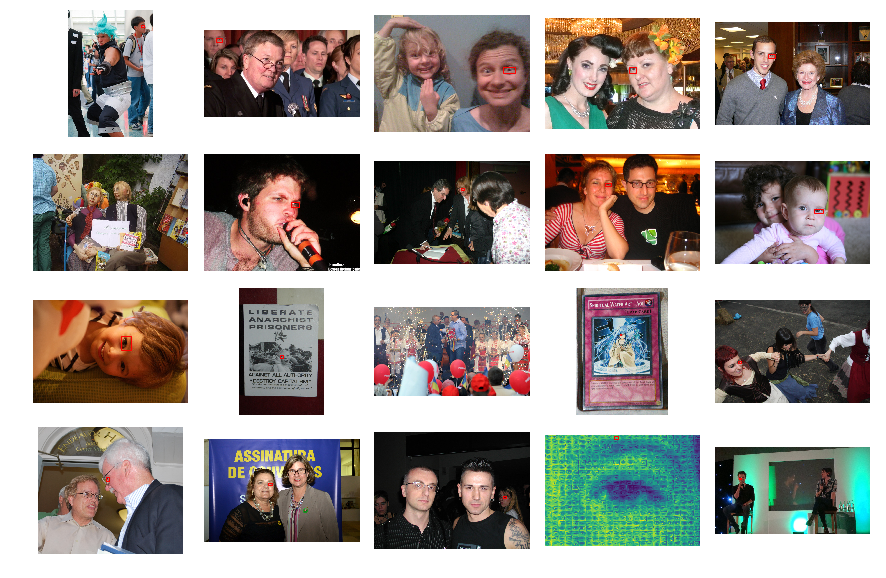

In [14]:
from funcy import first, second, curry
import matplotlib as mpl
from random import sample as rand_subset
import imagesize

mpl.rcParams['figure.figsize'] = (15, 10)

def bounding_box(path, row):
    w, h = imagesize.get(path)
    x1, x2 = row.at['XMin'], row.at['XMax']
    y1, y2 = row.at['YMin'], row.at['YMax']
    return x1 * w, x2 * w, y1 * h, y2 * h

def bounding_rect(row, image):
    x1, x2, y1, y2 = bounding_box(image, row)
    return mpl.patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1,
        linewidth=1,
        edgecolor='r',
        facecolor='none')

def display_box(row, axis = None):
    path = oi.image_path(row)
    image = plt.imread(path)
    axis.imshow(image)
    axis.set_axis_off()
    axis.add_patch(bounding_rect(row, path))

IMAGE_COLS = 5
IMAGE_ROWS = 4

figure, axarr = plt.subplots(IMAGE_ROWS, IMAGE_COLS,
                             gridspec_kw = dict(wspace=0.1, hspace=0.1))

random_indices = rand_subset(range(oi.train_ann_bbox().shape[0]), IMAGE_COLS * IMAGE_ROWS)

for idx, axis in zip(random_indices, axarr.flatten()):
    display_box(oi.train_ann_bbox().iloc[idx], axis)

# Prepare Yolo V3 (Keras version) for Training 

https://github.com/qqwweee/keras-yolo3

In [12]:
import progressbar
from os import remove as rm

YOLO_ANCHORS_FILE = './annotations-yolo-format.txt'

# rm(YOLO_ANCHORS_FILE)

def open_image_to_darknet_format(image_id, group):
    path = oi.image_path(group.iloc[0])
    boxes = group.apply(lambda r: bounding_box(path, r), axis=1).values.tolist()
    return path + ' ' + ' '.join([','.join(map(compose(str, round), b)) + ',0' for b in boxes])

# with open(YOLO_ANCHORS_FILE, 'w') as file:
#     with progressbar.ProgressBar(max_value=oi.train_ann_bbox().ImageID.nunique()) as bar:
#         i = 0
#         for image_id, group in oi.train_ann_bbox().groupby('ImageID'):
#             file.write("%s\n" % open_image_to_darknet_format(image_id, group))
#             i += 1
#             bar.update(i)

In [13]:
# Print sample
print('Sample output:')
print('\n'.join([open_image_to_darknet_format(i, g)
                 for i, g in oi.train_ann_bbox()[0:10].groupby('ImageID')]))

Sample output:
/media/rcdilorenzo/datahouse/openimagesv4/train_08/000004f4400f6ec5.jpg 489,509,274,303,0 618,645,216,232,0 675,696,219,229,0
/media/rcdilorenzo/datahouse/openimagesv4/train_08/0000271195f2c007.jpg 424,522,429,486,0 573,650,440,494,0
/media/rcdilorenzo/datahouse/openimagesv4/train_08/000077165b72a53b.jpg 320,387,277,326,0 434,483,290,334,0
/media/rcdilorenzo/datahouse/openimagesv4/train_08/00007902a7b96e8c.jpg 429,451,246,261,0 473,483,247,263,0
/media/rcdilorenzo/datahouse/openimagesv4/train_08/0000bdfa52154160.jpg 266,314,213,236,0


In [15]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
import keras.backend as K

K.clear_session()

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75)

sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
K.set_session(sess)

/home/rcdilorenzo/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
import train
import numpy as np
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

VERSION_NAME = 'v4-12k-adam1e3-train10'

YOLO_ANCHORS_FILE = './annotations-yolo-format.txt'
MAX_LINES = 12000
YOLO_FILE = os.path.join(YOLO_DIR, 'yolov3-320.h5')
MODEL_DIR = './models/' + VERSION_NAME
LOG_DIR = './logs/' + VERSION_NAME + '/'
CLASSES_FILE = './classes-yolo-format.txt'
ANCHORS_FILE = './keras-yolo3/model_data/yolo_anchors.txt'
TEMP_MODEL_FORMAT = 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
BATCH_SIZE = 32
BATCH_SIZE_FINE_TUNE = 32
TRAIN_WITH_FROZEN = True
FINE_TUNE_TRAIN = True

class_names = train.get_classes(CLASSES_FILE)
num_classes = len(class_names)
anchors = train.get_anchors(ANCHORS_FILE)

input_shape = (416, 416) # multiple of 32, hw

model = train.create_model(input_shape, anchors, num_classes, freeze_body=2, weights_path=YOLO_FILE)

logging = TensorBoard(log_dir=LOG_DIR)

checkpoint = ModelCheckpoint(
    os.path.join(MODEL_DIR, TEMP_MODEL_FORMAT),
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

val_split = 0.1
with open(YOLO_ANCHORS_FILE) as f:
    lines = f.readlines()
        
# Shuffle
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)

# Cap at maximum
lines = lines[0:MAX_LINES]
print('Total records: ', len(lines))

num_val = int(len(lines) * val_split)
num_train = len(lines) - num_val
train_steps = lambda size: max(1, num_train // size)
val_steps = lambda size: max(1, num_val // size)

def data_generator(subset, size):
    return train.data_generator_wrapper(subset, size, input_shape, anchors, num_classes)

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
if TRAIN_WITH_FROZEN:
    for i in range(len(model.layers) - 10, len(model.layers)):
        model.layers[i].trainable = True
    
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    print('Train on {} samples, val on {} samples, with batch size {}.'.format(
        num_train, num_val, BATCH_SIZE))
    
    model.fit_generator(
        data_generator(lines[:num_train], BATCH_SIZE),
        steps_per_epoch=train_steps(BATCH_SIZE),
        validation_data=data_generator(lines[num_train:], BATCH_SIZE),
        validation_steps=val_steps(BATCH_SIZE),
        epochs=100,
        initial_epoch=0,
        callbacks=[logging, checkpoint]
    )
    
    model.save_weights(os.path.join(MODEL_DIR, 'trained_weights_base.h5'))


if FINE_TUNE_TRAIN:
    # Unfreeze
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
        
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred})
    print('Unfreeze all of the layers.')

    print('Train on {} samples, val on {} samples, with batch size {}.'.format(
        num_train, num_val, BATCH_SIZE_FINE_TUNE))
    
    model.fit_generator(
        data_generator(lines[:num_train], BATCH_SIZE_FINE_TUNE),
        steps_per_epoch=train_steps(BATCH_SIZE_FINE_TUNE),
        validation_data=data_generator(lines[num_train:], BATCH_SIZE_FINE_TUNE),
        validation_steps=val_steps(BATCH_SIZE_FINE_TUNE),
        epochs=100,
        initial_epoch=50,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping]
    )
    
    model.save_weights(os.path.join(MODEL_DIR, 'trained_weights_final.h5'))

Create YOLOv3 model with 9 anchors and 1 classes.


/home/rcdilorenzo/.local/lib/python3.6/site-packages/keras/engine/topology.py:3473: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 18) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/home/rcdilorenzo/.local/lib/python3.6/site-packages/keras/engine/topology.py:3473: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((18,) vs (255,)).
  weight_values[i].shape))
/home/rcdilorenzo/.local/lib/python3.6/site-packages/keras/engine/topology.py:3473: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 18) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/home/rcdilorenzo/.local/lib/python3.6/site-packages/keras/engine/topology.py:3473: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((18,) vs (255,)).
  weight_values[i].shape))
/home/rcdilorenzo/.local/lib/python3.6/site-packages/keras/engine/topology.py:3473: UserWarnin

Load weights /home/rcdilorenzo/workspaces/data/yolov3/yolov3-320.h5.
Freeze the first 249 layers of total 252 layers.
Total records:  12000
Train on 10800 samples, val on 1200 samples, with batch size 32.
Epoch 1/100
337/337 [==============================] - 633s 2s/step - loss: 315.2456 - val_loss: 34.9202
Epoch 2/100
337/337 [==============================] - 597s 2s/step - loss: 28.9559 - val_loss: 23.7155
Epoch 3/100
337/337 [==============================] - 590s 2s/step - loss: 22.4475 - val_loss: 20.3721
Epoch 4/100
337/337 [==============================] - 592s 2s/step - loss: 20.2299 - val_loss: 19.1477
Epoch 5/100
337/337 [==============================] - 605s 2s/step - loss: 19.1119 - val_loss: 18.4512
Epoch 6/100
337/337 [==============================] - 590s 2s/step - loss: 18.4901 - val_loss: 18.4590
Epoch 7/100
337/337 [==============================] - 591s 2s/step - loss: 18.2391 - val_loss: 17.5035
Epoch 8/100
337/337 [==============================] - 591s 2s/ste